In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36331")
client

<Client: 'tcp://127.0.0.1:36331' processes=8 threads=32, memory=246.60 GiB>

# Explore the sea level decomposition on the Northwest European Shelf (NWES)
- Code is based on *decomp_SSH_full.ipynb*

In [80]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors
from matplotlib.colors import BoundaryNorm

import zarr
import gsw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [4]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [5]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

# MZZ files have been downloaded. 
# select the SSH dataset
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'

# mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')
# TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_day_mean_native_llc090_ECCOV4r5.json'
# DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_day_mean_native_llc090_ECCOV4r5.json'
# PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_day_mean_native_llc090_ECCOV4r5.json'
# SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_day_mean_native_llc090_ECCOV4r5.json'

# np.sort(list(mzz_local_directory.glob('*json')))

print(TS_file)
print(DEN_file)
print(PRE_file)
print(SSH_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json


# load mon means: SSH, pressure, T,S

## load grid

In [6]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'

# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

# 1. read data (all times), SSH, pressure, density, T/S

In [7]:
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

# 
fs_DEN = fsspec.filesystem("reference",     
                       fo=str(DEN_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DEN.asynchronous = True
store = zarr.storage.FsspecStore(fs_DEN)
ds_DEN = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_PRE = fsspec.filesystem("reference",     
                       fo=str(PRE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_PRE.asynchronous = True
store = zarr.storage.FsspecStore(fs_PRE)
ds_PRE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


In [8]:
itime = ((ds_PRE.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_PRE.time <= np.array(datetime.datetime(2019,12,31)).astype('datetime64[ns]')))

# itime = ((ds_PRE.time >= np.array(datetime.datetime(2013,1,1)).astype('datetime64[ns]')) & 
#          (ds_PRE.time <= np.array(datetime.datetime(2013,12,31)).astype('datetime64[ns]')))

eta = ds_SSH.SSH[itime,:,:,:].compute() 
etan = ds_SSH.ETAN[itime,:,:,:].compute()
rhoanom = ds_DEN.RHOAnoma[itime,:,:,:].compute()
phihy = ds_DEN.PHIHYDcR[itime,:,:,:,:].compute()
temp_pot = ds_TS.THETA[itime,:,:,:].compute()
sal_abs = ds_TS.SALT[itime,:,:,:].compute()


# some parameters

In [9]:
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa
S_Ar = 35.16504    # absolute salinity standard for spec. vol., notated as SSO in GSW documentation
T_Cr = 0.    # conservative temperature standard
temp_cons = gsw.conversions.CT_from_pt(sal_abs,temp_pot)
press = (phihy + (g*(-ds_grid.Z)))*rhoConst   # pressure
press_sea = press - p_atm    # pressure minus mean atmospheric pressure

# 2. manometric component $\eta_m = \frac{p_b}{\rho_0 g}$

In [10]:
eta_m = ds_PRE.OBP[itime,:,:,:].compute()

# 3. steric component $- \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{\rho'}dz^* $

In [11]:
rhoanom_tm = rhoanom.mean(dim='time')

sstar = (ds_grid.Depth + etan) / ds_grid.Depth
dzs = ds_grid.drF * ds_grid.hFacC

rho_zsum = ((rhoanom - rhoanom_tm) * dzs).sum(dim='k')
# rho_zsum = (rhoanom * dzs).sum(dim='k')
eta_s = - 1/rhoConst * sstar * rho_zsum 
eta_s = eta_s.transpose('time', 'tile', 'j', 'i')

# 4. decompose $\eta_s$ into thermosteric and halosteric parts:
## $\eta_{s-T} = - \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{ [\rho(S_r,T,p) - \rho(S_r,T_r,p)] }dz^* $
## $\eta_{s-S} = - \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{ [\rho(S,T_r,p) - \rho(S_r,T_r,p)] }dz^* $

In [12]:
den_thermo_anom = gsw.density.rho(S_Ar,temp_cons,(1.e-4)*press_sea.values) - rhoConst
den_halo_anom = gsw.density.rho(sal_abs,T_Cr,(1.e-4)*press_sea.values) - rhoConst

# integrate vertically to obtain height anomalies
eta_s_T = -(den_thermo_anom * ds_grid.drF * ds_grid.hFacC).sum("k") * sstar / rhoConst
eta_s_S = -(den_halo_anom * ds_grid.drF * ds_grid.hFacC).sum("k") * sstar / rhoConst

# 5. Statistical processing: remove seasonal cycles, calc trends, etc.

## anomalies

In [13]:
eta_anom = eta - eta[0,:,:,:]
etam_anom = eta_m - eta_m[0,:,:,:]
etas_anom = eta_s - eta_s[0,:,:,:]
etas_T_anom = eta_s_T - eta_s_T[0,:,:,:]
etas_S_anom = eta_s_S - eta_s_S[0,:,:,:]

## remove seasonal cycles

In [14]:
eta_clim = eta_anom.groupby("time.month").mean()
eta_dess = eta_anom.groupby('time.month') - eta_clim

etam_clim = etam_anom.groupby("time.month").mean()
etam_dess = etam_anom.groupby('time.month') - etam_clim

etas_clim = etas_anom.groupby("time.month").mean()
etas_dess = etas_anom.groupby('time.month') - etas_clim

etasT_clim = etas_T_anom.groupby("time.month").mean()
etasT_dess = etas_T_anom.groupby('time.month') - etasT_clim

etasS_clim = etas_S_anom.groupby("time.month").mean()
etasS_dess = etas_S_anom.groupby('time.month') - etasS_clim

## calc global mean and local linear trends

In [15]:
# ---- global mean
eta_area = eta_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) 
etam_area = etam_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_area = etas_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_T_area = etas_T_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_S_area = etas_S_anom.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
# dess
eta_dess_area = eta_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i")) 
etam_dess_area = etam_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_dess_area = etas_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_T_dess_area = etasT_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))
etas_S_dess_area = etasS_dess.weighted(ds_grid.rA).mean(dim=('tile', "j", "i"))

# ---- trends
fac = 12*1e3*2548800000000000  # m/mon -> mm/yr
# 
poly = eta_anom.polyfit(dim='time',deg=1)
trend_eta = poly.polyfit_coefficients.sel(degree=1) *fac 
# mano
poly = etam_anom.polyfit(dim='time',deg=1)
trend_etam = poly.polyfit_coefficients.sel(degree=1) *fac
# steric
poly = etas_anom.polyfit(dim='time',deg=1)
trend_etas = poly.polyfit_coefficients.sel(degree=1) *fac
# thermo
poly = etas_T_anom.polyfit(dim='time',deg=1)
trend_etas_T = poly.polyfit_coefficients.sel(degree=1) *fac
# halo
poly = etas_S_anom.polyfit(dim='time',deg=1)
trend_etas_S = poly.polyfit_coefficients.sel(degree=1) *fac

# dess
poly = eta_dess.polyfit(dim='time',deg=1)
trend_eta_dess = poly.polyfit_coefficients.sel(degree=1) *fac 
# mano
poly = etam_dess.polyfit(dim='time',deg=1)
trend_etam_dess = poly.polyfit_coefficients.sel(degree=1) *fac
# steric
poly = etas_dess.polyfit(dim='time',deg=1)
trend_etas_dess = poly.polyfit_coefficients.sel(degree=1) *fac
# thermo
poly = etasT_dess.polyfit(dim='time',deg=1)
trend_etas_T_dess = poly.polyfit_coefficients.sel(degree=1) *fac
# halo
poly = etasS_dess.polyfit(dim='time',deg=1)
trend_etas_S_dess = poly.polyfit_coefficients.sel(degree=1) *fac

## residuals

In [16]:
eta_tm = eta_anom[:,:,:,:].mean(dim='time')
etam_tm = etam_anom[:,:,:,:].mean(dim='time')
etas_tm = etas_anom[:,:,:,:].mean(dim='time')
etasT_tm = etas_T_anom[:,:,:,:].mean(dim='time')
etasS_tm = etas_S_anom[:,:,:,:].mean(dim='time')

res_eta = eta_anom - etam_anom - etas_anom
res_steric = etas_anom - etas_T_anom - etas_S_anom

std_res_eta = res_eta.std(dim='time') / eta_anom.std(dim='time')
std_res_etas = res_steric.std(dim='time') / etas_anom.std(dim='time')

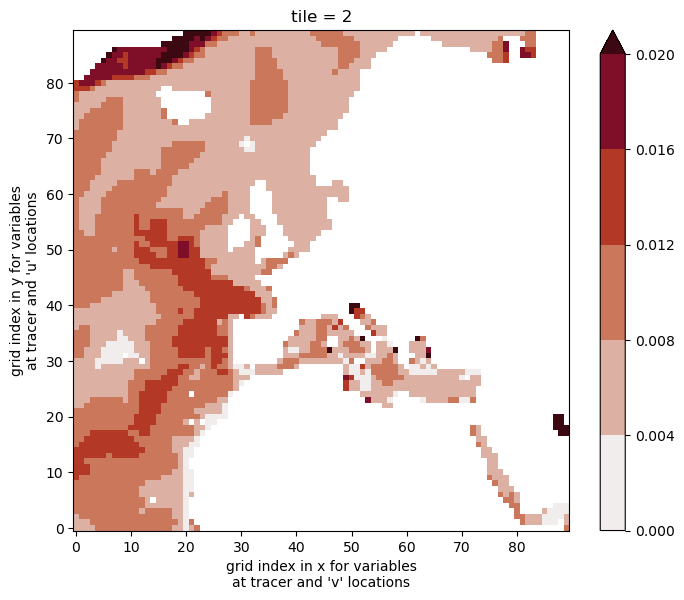

In [17]:
fig=plt.figure(figsize=(8, 6.5))
std_res_eta.isel(tile=2).plot(vmin=.0, vmax=.02, cmap=cmocean.cm.amp, levels=6)
# plt.plot(std_res_eta.isel(tile=2))
# plt.pcolormesh(std_res_eta.isel(tile=2), shading="auto", cmap=cmocean.cm.amp)
# plt.colorbar

# 6. Select NWES
: calc area mean

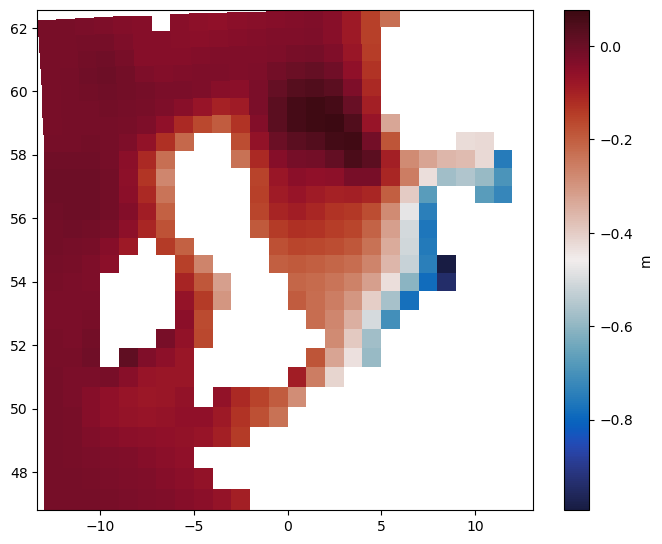

In [138]:
jsel = np.arange(43, 70, 1) 
isel = np.arange(25, 51, 1)
eta_sub = eta_anom[:, 2, jsel, isel].squeeze()
etam_sub = etam_anom[:, 2, jsel, isel].squeeze()
etas_sub = etas_anom[:, 2, jsel, isel].squeeze()
etasT_sub = etas_T_anom[:, 2, jsel, isel].squeeze()
etasS_sub = etas_S_anom[:, 2, jsel, isel].squeeze()

# 
eta_mean = eta_sub.weighted(ds_grid.rA[2, jsel, isel]).mean(dim=("j", "i")) 
etam_mean = etam_sub.weighted(ds_grid.rA[2, jsel, isel]).mean(dim=("j", "i")) 
etas_mean = etas_sub.weighted(ds_grid.rA[2, jsel, isel]).mean(dim=("j", "i")) 
etasT_mean = etasT_sub.weighted(ds_grid.rA[2, jsel, isel]).mean(dim=("j", "i")) 
etasS_mean = etasS_sub.weighted(ds_grid.rA[2, jsel, isel]).mean(dim=("j", "i")) 
# remove time mean
eta_mean = eta_mean - eta_mean.mean(dim='time')
etam_mean = etam_mean - etam_mean.mean(dim='time')
etas_mean = etas_mean - etas_mean.mean(dim='time')
etasT_mean = etasT_mean - etasT_mean.mean(dim='time')
etasS_mean = etasS_mean - etasS_mean.mean(dim='time')

res_sub = eta_mean - etam_mean - etas_mean
ress_sub = etas_mean - etasT_mean - etasS_mean


# 
fig=plt.figure(figsize=(8, 6.5))
mesh = plt.pcolormesh(eta_sub.XC, eta_sub.YC, eta_sub[2,:,:], shading="auto", cmap=cmocean.cm.balance)
cbar = plt.colorbar(mesh)
cbar.set_label("m")

## plot outlines of the region

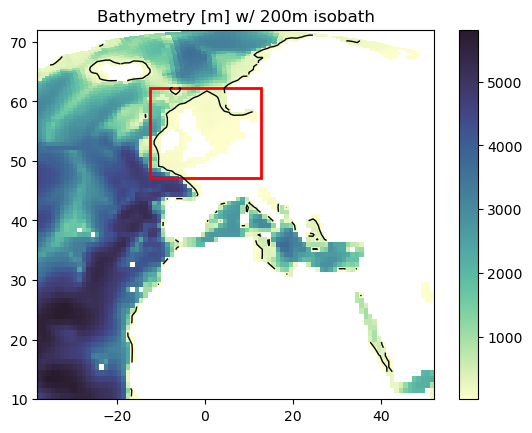

In [144]:
depth_masked = ds_grid.ocean_column_thickness.where(ds_grid.maskC)

x0 = ds_grid.XC[2, jsel[0], isel[0]]
y0 = ds_grid.YC[2, jsel[0], isel[0]]
dx = ds_grid.XC[2, jsel[-1], isel[-1]] - ds_grid.XC[2, jsel[0], isel[0]]
dy = ds_grid.YC[2, jsel[-1], isel[-1]] - ds_grid.YC[2, jsel[0], isel[0]]

# fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig, ax = plt.subplots()
# ax.coastlines()
mesh = plt.pcolormesh(ds_grid.XC.isel(tile=2), ds_grid.YC.isel(tile=2), \
                      depth_masked.isel(tile=2,k=0), \
                      cmap=cmocean.cm.deep)
contours = ax.contour(ds_grid.XC.isel(tile=2), ds_grid.YC.isel(tile=2), \
                          depth_masked.isel(tile=2,k=0), levels=[200], colors='black', linewidths=1)
rect = Rectangle((x0, y0), dx, dy, linewidth=2, edgecolor='red', facecolor='none')

cbar = plt.colorbar(mesh)
ax.add_patch(rect)
plt.title('Bathymetry [m] w/ 200m isobath')

plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/bathy_NWES.png", dpi=600, bbox_inches='tight')

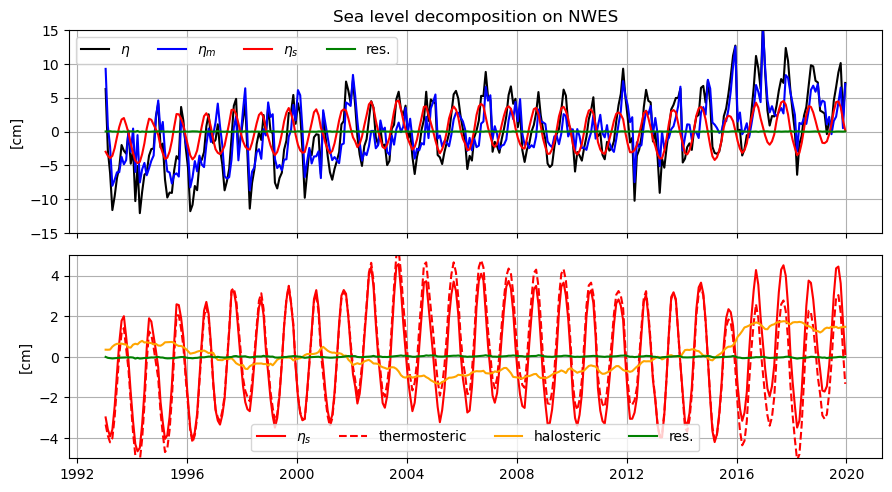

In [145]:
fac = 100

plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
plt.plot(eta_mean['time'], eta_mean*fac, label='$\eta$', color='k')
plt.plot(etam_mean['time'], etam_mean*fac, label='$\eta_m$', color='b')
plt.plot(etas_mean['time'], etas_mean*fac, label='$\eta_s$', color='r')
plt.plot(res_sub['time'], res_sub*fac, label='res.', color='g')
plt.legend(ncol=2)
plt.ylim(-15, 15)
plt.ylabel('[cm]')
plt.legend(ncol=4)
plt.grid(True) 
plt.title('Sea level decomposition on NWES')
# eta_sub
plt.xlabel('') 
ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(2,1,2)
plt.plot(etas_mean['time'], etas_mean*fac, label='$\eta_s$', color='r')
plt.plot(etasT_mean['time'], etasT_mean*fac, label='thermosteric', color='r', linestyle='--')
plt.plot(etasS_mean['time'], etasS_mean*fac, label='halosteric', color='orange')
plt.plot(ress_sub['time'], ress_sub*fac, label='res.', color='g')
plt.ylim(-5, 5)
plt.ylabel('[cm]')
plt.legend(ncol=4)
plt.grid(True) 
# plt.title('Steric sea level decomposition')
plt.tight_layout(pad=1.0)  # pad = space between plots

plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/NWES_SL_tseries.png", dpi=600, bbox_inches='tight')

# 7. calc corr with wind

## read wind stress

In [146]:
WIND_file = mzz_local_directory / 'OCEAN_AND_ICE_SURFACE_STRESS_mon_mean_native_llc090_ECCOV4r5.json'
fs_WND = fsspec.filesystem("reference",     
                       fo=str(WIND_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_WND.asynchronous = True
store = zarr.storage.FsspecStore(fs_WND)
ds_WND = xr.open_dataset(store, engine='zarr',
                     consolidated=False) # 

EXFtaux = ds_WND.EXFtaux[itime,:,:,:].compute() 
EXFtauy = ds_WND.EXFtauy[itime,:,:,:].compute() 

In [147]:
EXFtaux_clim = EXFtaux.groupby("time.month").mean()
EXFtaux_dess = EXFtaux.groupby('time.month') - EXFtaux_clim

EXFtauy_clim = EXFtauy.groupby("time.month").mean()
EXFtauy_dess = EXFtauy.groupby('time.month') - EXFtauy_clim

# NWES-mean SL, de-ss
EXFtaux_clim = EXFtaux.groupby("time.month").mean()
EXFtaux_dess = EXFtaux.groupby('time.month') - EXFtaux_clim


corr_m_taux = xr.corr(EXFtaux_dess[:,2,:,:], etam_mean, dim="time")
corr_m_tauy = xr.corr(EXFtauy_dess[:,2,:,:], etam_mean, dim="time")

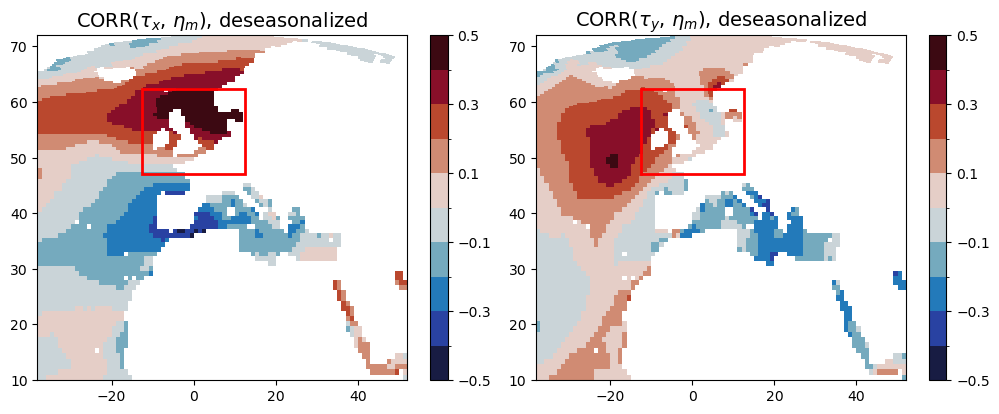

In [158]:
bounds = np.arange(-.5, .6, .1)
norm = BoundaryNorm(bounds, ncolors=256)
ticks = np.arange(-.5, .6, .2)

fig, axs = plt.subplots(1,2, figsize=(10, 4))
mesh = axs[0].pcolormesh(ds_grid.XC.isel(tile=2), ds_grid.YC.isel(tile=2), \
                         corr_m_taux, cmap=cmocean.cm.balance, norm=norm)
# contours = axs[0].contour(ds_grid.XC.isel(tile=2), ds_grid.YC.isel(tile=2), \
#                           depth_masked.isel(tile=2,k=0), levels=[200], colors='black', linewidths=1)
rect = Rectangle((x0, y0), dx, dy, linewidth=2, edgecolor='red', facecolor='none')
cbar = plt.colorbar(mesh, ticks=ticks)
axs[0].add_patch(rect)
axs[0].set_title(r"CORR($\tau_x$, $\eta_m$), deseasonalized",fontsize=14)

# 
mesh = axs[1].pcolormesh(ds_grid.XC.isel(tile=2), ds_grid.YC.isel(tile=2), \
                      corr_m_tauy, cmap=cmocean.cm.balance, norm=norm)
# contours = axs[1].contour(ds_grid.XC.isel(tile=2), ds_grid.YC.isel(tile=2), \
#                           depth_masked.isel(tile=2,k=0), levels=[200], colors='black', linewidths=1)
rect = Rectangle((x0, y0), dx, dy, linewidth=2, edgecolor='red', facecolor='none')
cbar = plt.colorbar(mesh, ticks=ticks)
axs[1].add_patch(rect)
axs[1].set_title(r"CORR($\tau_y$, $\eta_m$), deseasonalized",fontsize=14)

plt.tight_layout(pad=.2)  

# plt.savefig("/home/jovyan/ESS25-Team_PISEAL/figures/NWES_corr_tauetam.png", dpi=600, bbox_inches='tight')